# Single Star - Spectroscopic Observables

This notebook shows how you can use the `SingleStarModel` to infer stellar parameters with spectroscopic observables effective temperature, surface gravity, and metallicity (`Teff`, `log_g`, `M_H`).

Firstly, import packages.

In [1]:
import os, json
import numpy as np
import pandas as pd
import numpyro
import arviz as az
import matplotlib.pyplot as plt

from pprint import pprint
from corner import corner
from jax import random, vmap
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive

num_chains = 10
numpyro.enable_x64()
numpyro.set_host_device_count(num_chains)
# numpyro.set_platform("gpu")

Then, import the `SingleStarModel` from `celestify`.

In [2]:
from celestify.numpyro_models import SingleStarModel

## Truths

Let's synthesis some true parameters for our star from the `SingleStarModel` prior.

In [49]:
star = 508
directory = "/mnt/data-storage/alexlyttle/scalable-stellar-inference"
filename = "truths-nearest-neighbour-clean.csv"
truths = pd.read_csv(os.path.join(directory, filename), index_col=0)
truths = truths.loc[star].to_dict()
pprint(truths)

{'Dnu': 103.83927194500184,
 'L': 1.5015185912479336,
 'M_H': -0.643485966667003,
 'R': 1.1144246352741027,
 'Teff': 6052.487579888205,
 'Y': 0.2515094,
 'Zinit': 0.00306617,
 'a_MLT': 2.063446,
 'abs_BP': 4.530337025897182,
 'abs_G': 4.268364234002248,
 'abs_RP': 3.837828581909117,
 'age': 11.72512086977578,
 'bol_mag': 4.308673215395094,
 'center_h1': 0.0151037733840723,
 'delta_Pg': 0.0,
 'delta_X': 0.7303206566159277,
 'eps_o': 1.3010262797494054,
 'evol': 0.2178051888656192,
 'f_nuc': 0.99985079961223,
 'fov_core': 0.0,
 'fov_shell': 0.006041,
 'index': 1594444.0,
 'kron': 6248273607.827202,
 'log_Dnu': 2.016361634470001,
 'log_L': 0.1765307138419622,
 'log_LHe': -35.56731404083557,
 'log_Lnuc': 0.1764659121025134,
 'log_R': 0.0470507039591118,
 'log_Teff': 3.781933906913184,
 'log_Zinit': -2.513403769894176,
 'log_age': 1.0691173283855075,
 'log_g': 4.2585420663762585,
 'log_kron': 9.795760038757823,
 'log_mass': -0.0854241530086507,
 'log_numax': 3.300129098010874,
 'log_star_ag

In [50]:
filename = "truths.json"
hyperparam_names = ["mu_a", "sigma_a", "Y_0", "dY_dZ", "sigma_Y"]

# SAVE TRUTHS
with open(os.path.join(directory, filename), "r") as file:
    s = file.read()
    json_dict = json.loads(s)
    for name in hyperparam_names:
        truths[name] = json_dict[name]

In [51]:
filename = "observables.csv"
obs = pd.read_csv(os.path.join(directory, filename), index_col=0)
obs = obs.loc[star].to_dict()
pprint(obs)

{'M_H': -0.7259337306022644,
 'log_Dnu': 2.017082691192627,
 'log_L': 0.1745719611644745,
 'log_Teff': 3.786431789398194,
 'sigma_M_H': 0.1,
 'sigma_log_Dnu': 0.0043429448190325,
 'sigma_log_L': 0.0043429448190325,
 'sigma_log_Teff': 0.0065144172285487}


## Model

Now, let's create our star model. We need to provide some model constants. These are typically shape parameters for prior distributions. You can see the full `dict` of constants in the `model.const` attribute.

In [52]:
rng = random.PRNGKey(0)
observables = ["log_Teff", "log_L", "log_Dnu"]

# Create dictionary of model constants
const = {
    "M_H": dict(loc=obs["M_H"], scale=obs["sigma_M_H"], low=-0.9, high=0.5),
}

# Create model
model = SingleStarModel(observables, const=const)

pprint(model.const)  # check all constants

{'M_H': {'high': 0.5, 'loc': -0.7259337306022644, 'low': -0.9, 'scale': 0.1},
 'Y': {'high': 0.32, 'low': 0.22},
 'Y_0': {'loc': 0.247, 'scale': 0.001},
 'a_MLT': {'high': 2.7, 'low': 1.3},
 'dY_dZ': {'high': 3.0, 'loc': 1.5, 'low': 0.0, 'scale': 1.0},
 'delta': {'cov': Array([[ 2.48329366e-06, -1.60093929e-07,  3.48753274e-07,
        -4.17365098e-07],
       [-1.60093929e-07,  8.63221086e-07, -5.92699039e-07,
         8.15505814e-07],
       [ 3.48753274e-07, -5.92699039e-07,  2.25046979e-06,
        -2.67737399e-06],
       [-4.17365098e-07,  8.15505814e-07, -2.67737399e-06,
         4.28433539e-06]], dtype=float64),
           'df': Array(4.18473434, dtype=float64, weak_type=True),
           'loc': Array([ 5.58302971e-04,  1.05638668e-04, -5.07872319e-05,  3.25894624e-04],      dtype=float64)},
 'log_evol': {'high': 0.0, 'loc': -0.7, 'scale': 0.4},
 'log_mass': {'high': 0.36172783601759284,
              'loc': 0.0,
              'low': -0.1549019599857432,
              'scale': 

## Prior Predictive

Sample from the model prior.

In [53]:
rng, key = random.split(rng)
prior_predictive = Predictive(model, num_samples=10000)
prior = prior_predictive(key)
y = prior.pop("y")
for i, key in enumerate(model.outputs):
    prior[key] = y[..., i]

In [54]:
from collections.abc import MutableMapping

def flatten_dict(dictionary, parent_key='', separator='_'):
    items = []
    for key, value in dictionary.items():
        new_key = parent_key + separator + key if parent_key else key
        if isinstance(value, MutableMapping):
            items.extend(flatten_dict(value, new_key, separator=separator).items())
        else:
            items.append((new_key, value))
    return dict(items)

Let's put the prior samples in an `arviz.InferenceData` class. This makes it easier to plot and save.

In [55]:
data = az.from_numpyro(prior=prior, constant_data=flatten_dict(model.const))
data

Inference data with groups:
	> prior
	> constant_data

We can plot the prior and overlay the true values with the `corner` package.

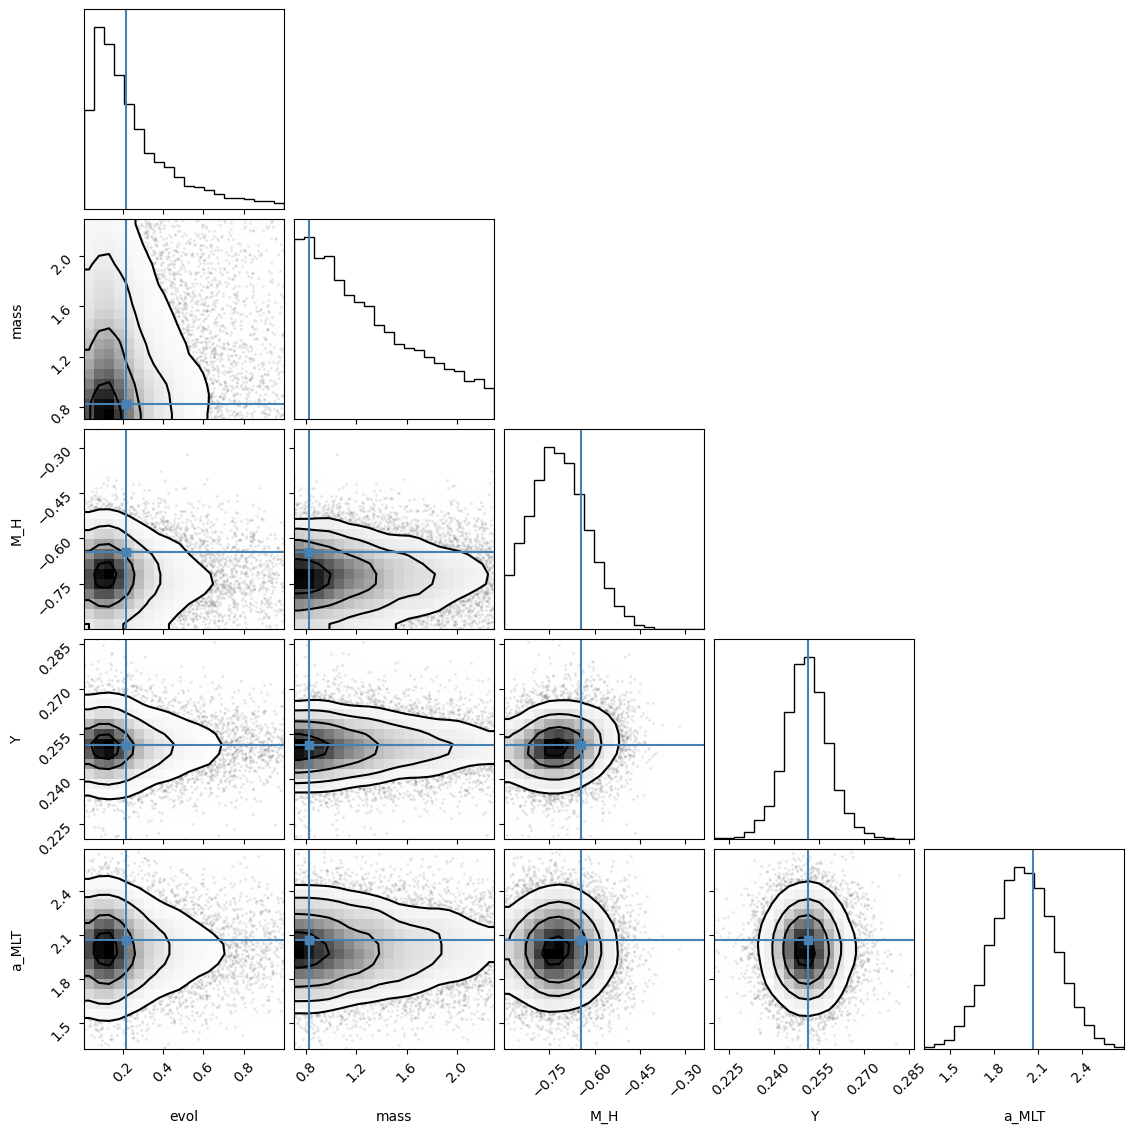

In [56]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
fig = corner(data, group="prior", var_names=var_names, truths=truths, smooth=1.)

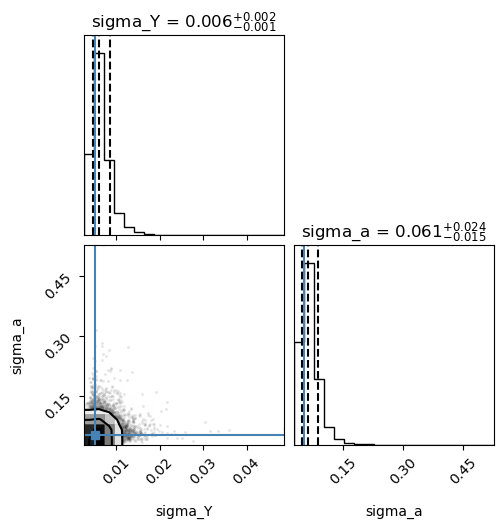

In [57]:
var_names = ["sigma_Y", "sigma_a"]
fig = corner(data, group="prior", var_names=var_names, truths=truths, smooth=1., quantiles=[.16, .5, .84], show_titles=True, title_fmt=".3f")

In [58]:
from corner import overplot_points, overplot_lines

Let's also look at some determinisitc parameters in the model.

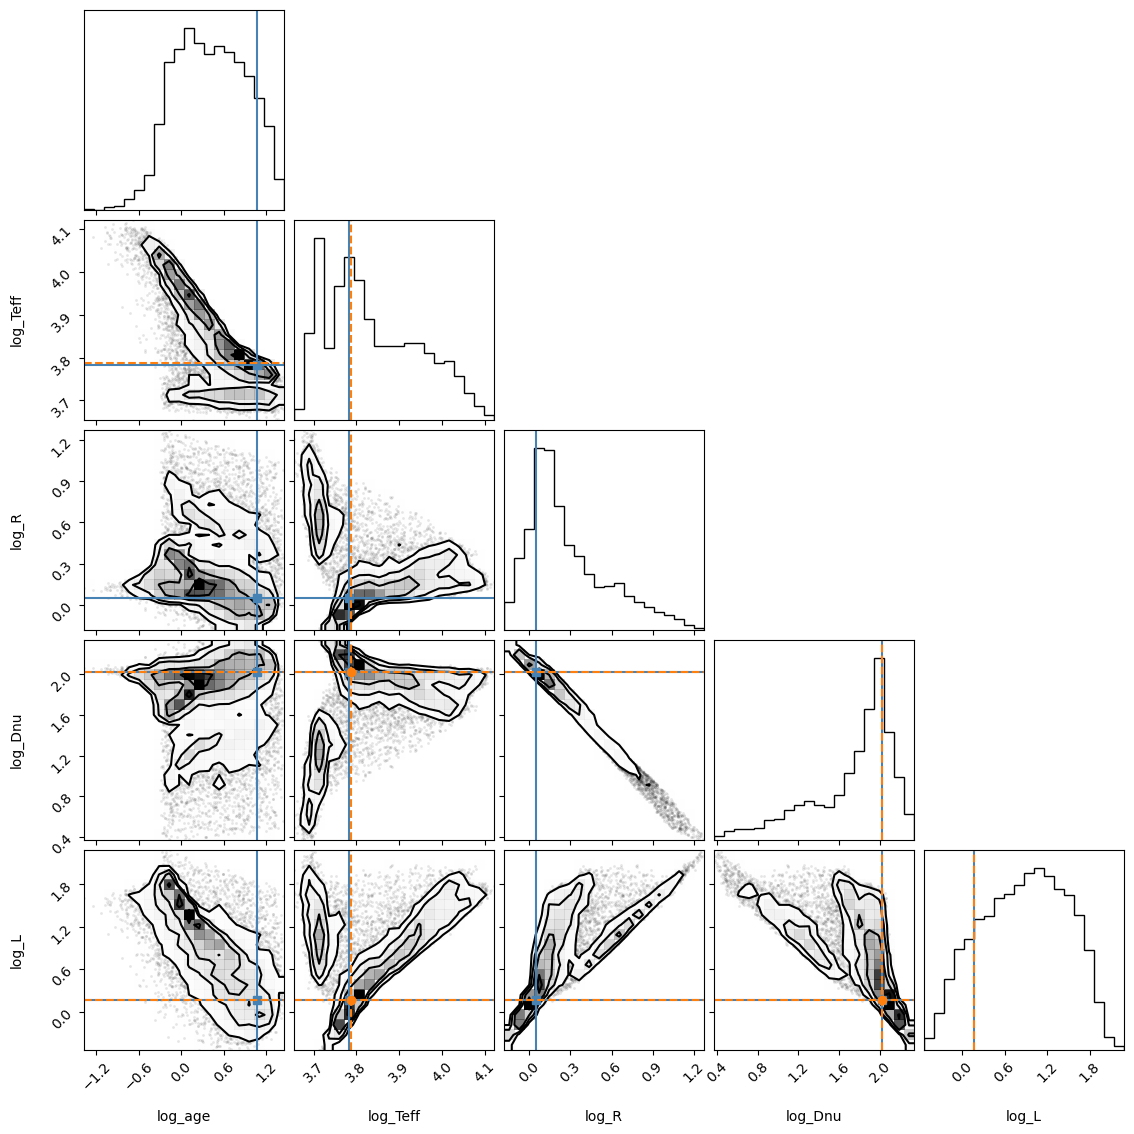

In [59]:
var_names = ["log_age", "log_Teff", "log_R", "log_Dnu", "log_L"]
fig = corner(data, group="prior", var_names=var_names, truths=truths)
xs = np.array([obs.get(k) for k in var_names])
overplot_lines(fig, xs, color="C1", ls="--")
overplot_points(fig, xs[None, ...], color="C1", marker="o")

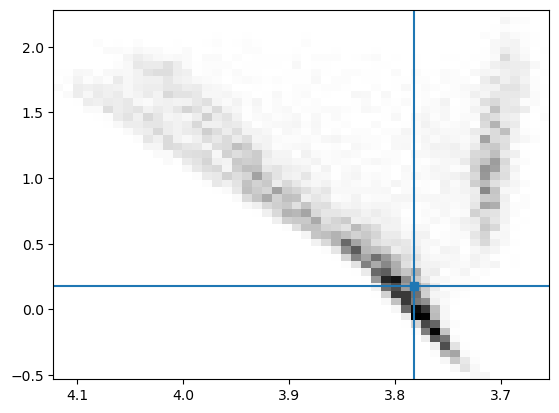

In [60]:
fig, ax = plt.subplots()

ax.hist2d(
    data.prior.log_Teff.squeeze(),
    data.prior.log_L.squeeze(),
    bins=50,
    cmap="Greys"
)
ax.axvline(truths["log_Teff"])
ax.axhline(truths["log_L"])
ax.plot(truths["log_Teff"], truths["log_L"], "s")
ax.invert_xaxis()

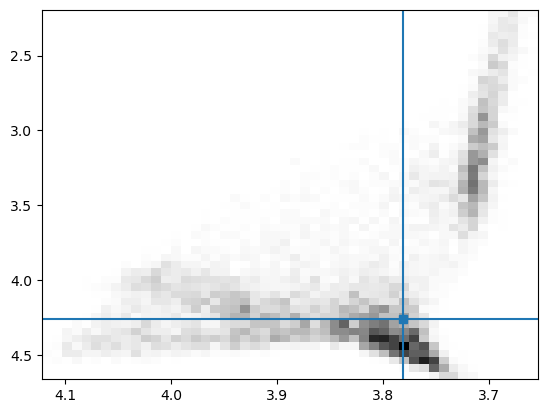

In [61]:
fig, ax = plt.subplots()

ax.hist2d(
    data.prior.log_Teff.squeeze(),
    data.prior.log_g.squeeze(),
    bins=50,
    cmap="Greys"
)
ax.axvline(truths["log_Teff"])
ax.axhline(truths["log_g"])
ax.plot(truths["log_Teff"], truths["log_g"], "s")
ax.invert_xaxis()
ax.invert_yaxis()

## Observation

In [62]:
y = np.stack([obs[key] for key in observables], axis=-1)
diag = np.stack([obs[f"sigma_{key}"] for key in observables], axis=-1)**2
print(y)
print(diag)

[3.78643179 0.17457196 2.01708269]
[4.24376318e-05 1.88611697e-05 1.88611697e-05]


## Sampling

Let's use the No U-Turn Sampler (NUTS) as our Markov Chain Monte Carlo (MCMC) sampling algorithm.

In [63]:
num_warmup, num_samples = 2000, 2000

sampler = NUTS(model, target_accept_prob=0.8, find_heuristic_step_size=True)
mcmc = MCMC(sampler, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

Let's run the MCMC and print a summary of results.

In [64]:
rng, key = random.split(rng)
mcmc.run(key, obs=y, diag=diag)
mcmc.print_summary()

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
               M_H     -0.72      0.09     -0.73     -0.88     -0.59  10214.11      1.00
                 Y      0.25      0.01      0.25      0.24      0.26  10669.27      1.00
             a_MLT      1.99      0.21      1.99      1.64      2.34   9887.21      1.00
          log_evol     -0.66      0.03     -0.66     -0.71     -0.62   7064.20      1.00
          log_mass     -0.09      0.01     -0.09     -0.11     -0.07   6920.35      1.00
       precision_Y  29986.99  17378.44  26702.81   4472.79  54776.69  14421.17      1.00
       precision_a    297.64    171.24    265.07     50.50    547.00  18481.56      1.00
  scaled_precision      1.01      0.69      0.86      0.06      1.97  17865.79      1.00

Number of divergences: 1


Looks pretty good. We want `r_hat` to be close to 1.0 (e.g. less than 1.1). We also want the number of divergances to be very small.

Let's update our `InferenceData`.

In [65]:
posterior = mcmc.get_samples(group_by_chain=True)

rng, key = random.split(rng)
posterior_predictive = Predictive(model, posterior_samples=posterior, parallel=True, return_sites=["y"], batch_ndims=2)
y = posterior_predictive(key)["y"]

for i, key in enumerate(model.outputs):
    posterior[key] = y[..., i]

In [66]:
sample_stats = mcmc.get_extra_fields(group_by_chain=True)

In [67]:
data += az.from_dict(posterior, sample_stats=sample_stats)
# data += az.from_dict(posterior, sample_stats=sample_stats, coords=coords, dims=dims)
data

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> constant_data

With `arviz`, we can create a summary of the data.

In [68]:
stat_funcs = {
    "q_16": lambda x: np.quantile(x, .16),
    "q_50": lambda x: np.quantile(x, .5),
    "q_84": lambda x: np.quantile(x, .84),
}
az.summary(data, fmt="xarray", stat_funcs=stat_funcs)

<xarray.Dataset>
Dimensions:           (metric: 12)
Coordinates:
  * metric            (metric) <U9 'mean' 'sd' 'hdi_3%' ... 'q_16' 'q_50' 'q_84'
Data variables: (12/19)
    M_H               (metric) float64 -0.7227 0.08774 ... -0.7266 -0.6331
    Y                 (metric) float64 0.2513 0.007514 0.2373 ... 0.2511 0.2583
    a_MLT             (metric) float64 1.995 0.2099 1.606 ... 1.787 1.991 2.205
    evol              (metric) float64 0.2174 0.0149 0.1876 ... 0.2186 0.2319
    log_evol          (metric) float64 -0.6637 0.03049 ... -0.6604 -0.6346
    log_mass          (metric) float64 -0.09138 0.01285 ... -0.09216 -0.07885
    ...                ...
    log_Teff          (metric) float64 3.783 0.002836 3.778 ... 3.78 3.783 3.786
    log_R             (metric) float64 0.04394 0.0052 ... 0.04377 0.04899
    log_Dnu           (metric) float64 2.018 0.005767 2.007 ... 2.018 2.023
    log_L             (metric) float64 0.1753 0.008099 0.1607 ... 0.1752 0.1826
    log_g             (metric) float64 4.259 0.01048 4.239 ... 4.249 4.259 4.269
    log_numax         (metric) float64 3.3 0.01028 3.281 3.319 ... 3.29 3.3 3.31

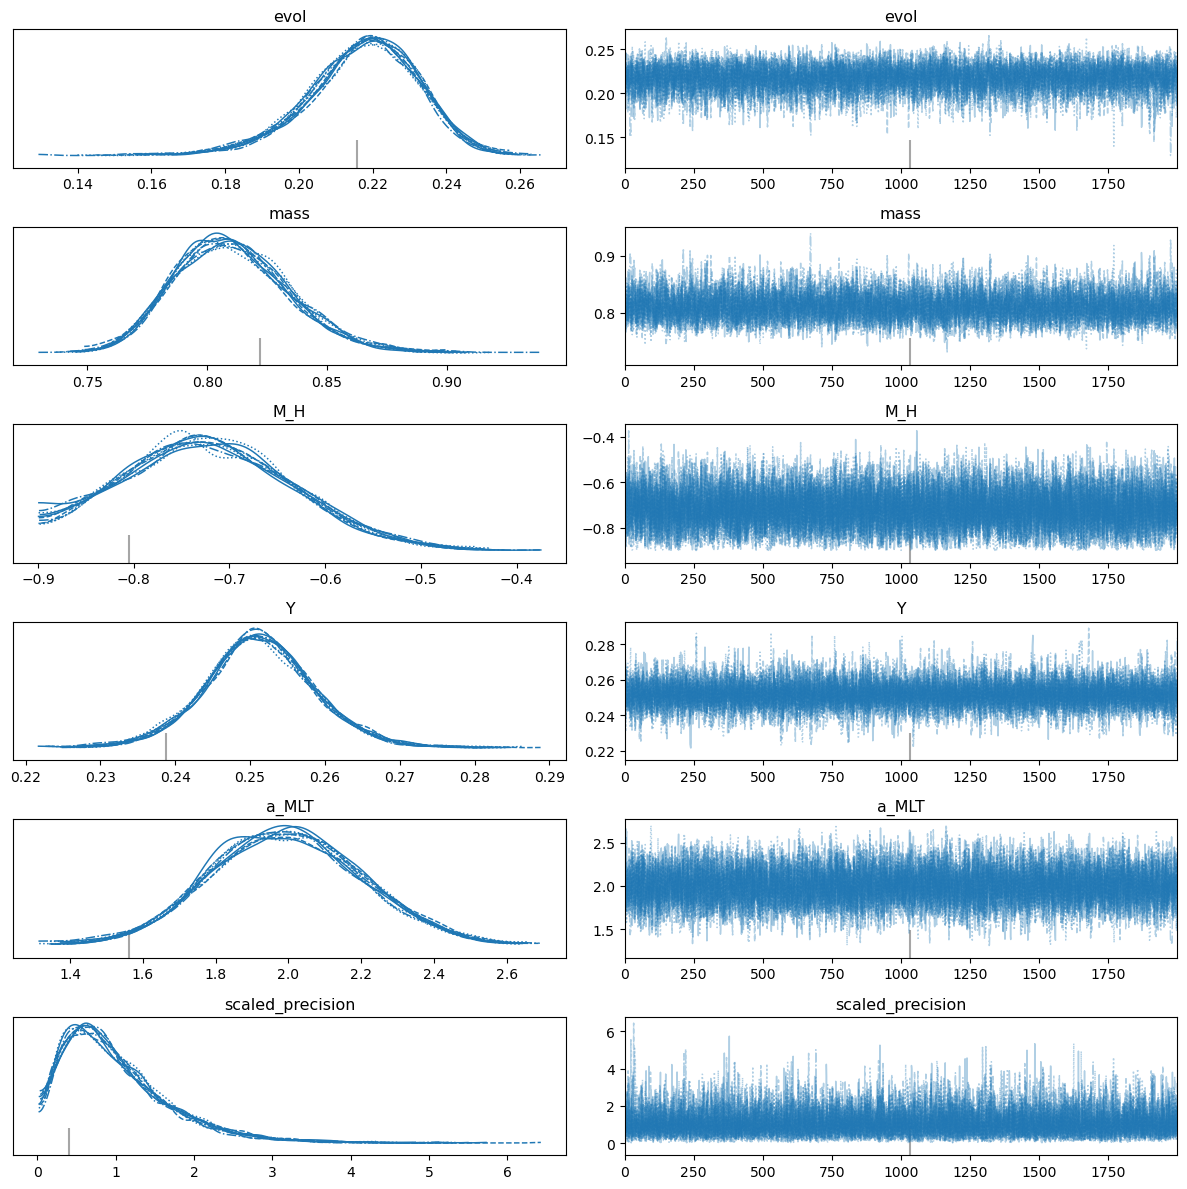

In [69]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT", "scaled_precision"]
az.plot_trace(data, var_names=var_names)
plt.tight_layout()

## Posterior Predictive

Let's check the joint posterior distributions and compare with the truth values.

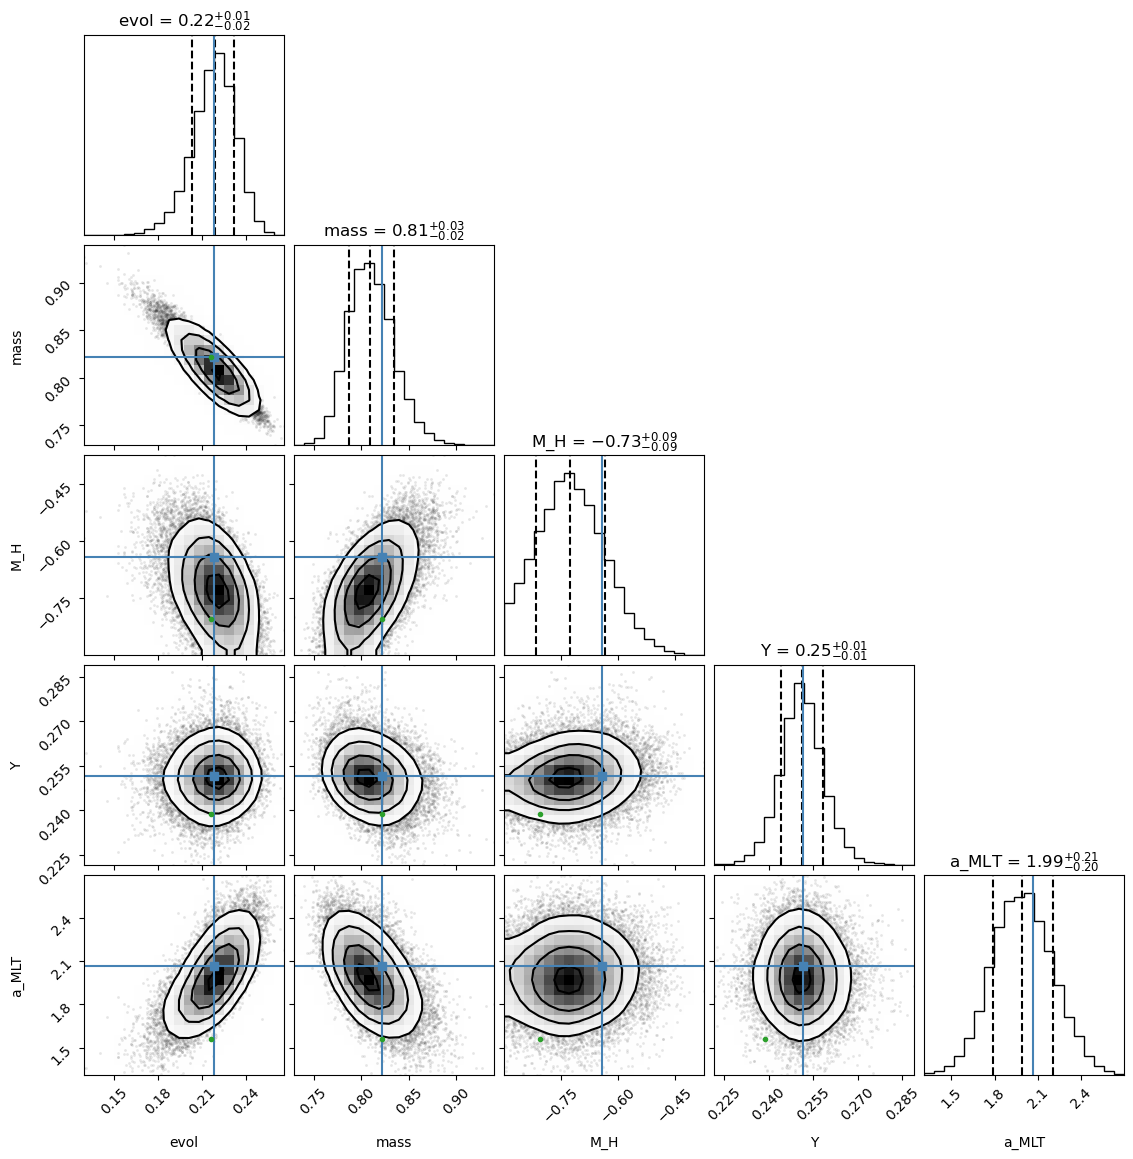

In [70]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
divergences_kwargs = dict(c="C2")
fig = corner(data, group="posterior", var_names=var_names, truths=truths, show_titles=True, divergences=True, divergences_kwargs=divergences_kwargs, quantiles=[.16, .5, .84], smooth=1.)

What do we predict for some deterministics?

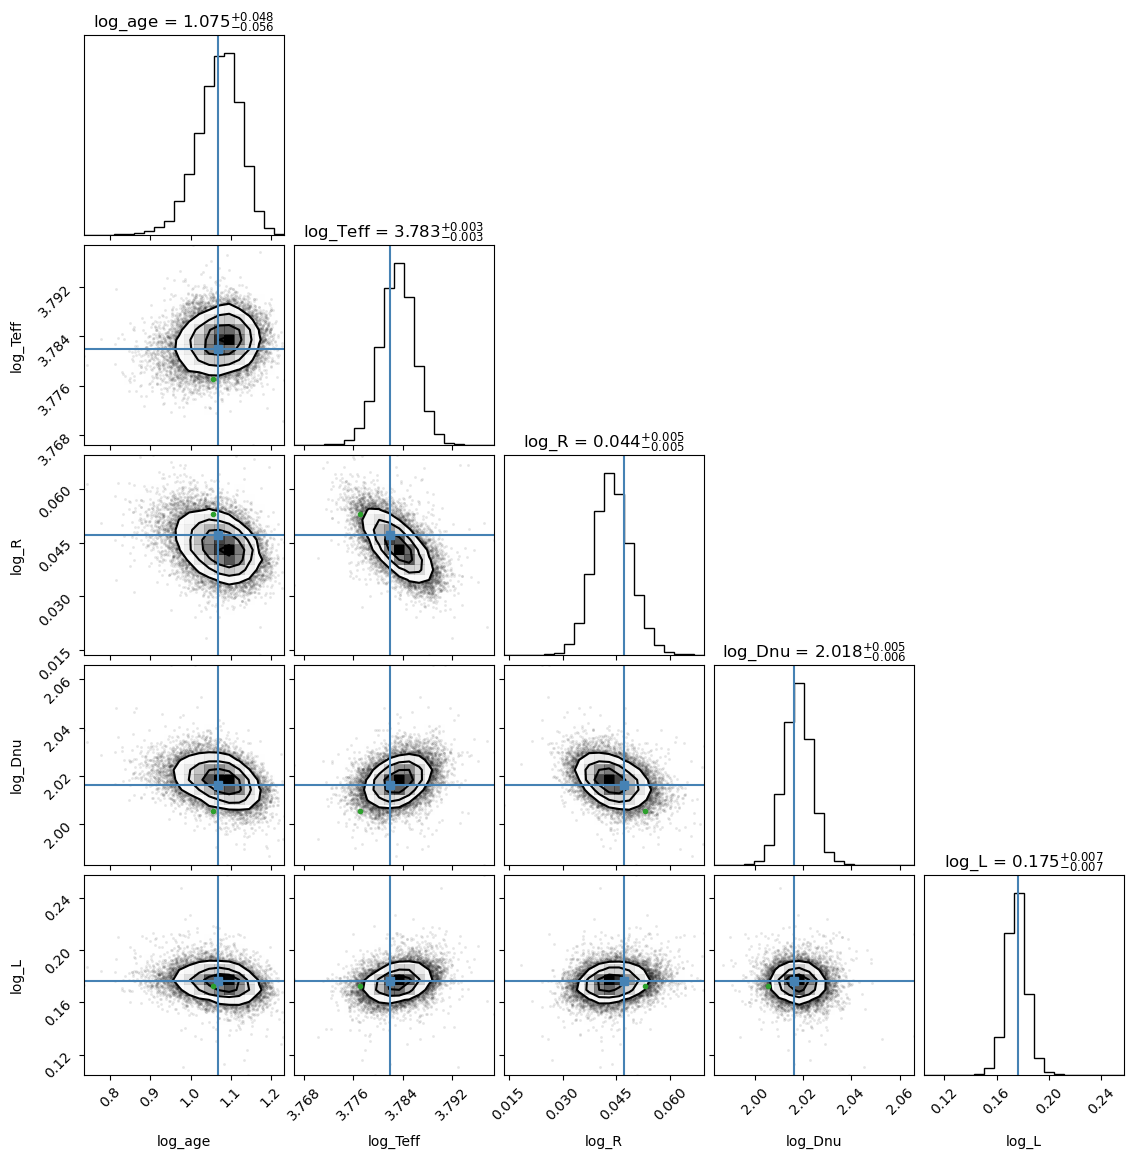

In [71]:
var_names = ["log_age", "log_Teff", "log_R", "log_Dnu", "log_L"]
fig = corner(data, var_names=var_names, truths=truths, show_titles=True, divergences=True, divergences_kwargs=divergences_kwargs, title_fmt=".3f")